In this notebook, we will explore the creation of the initial conditions for the Alaskan North Slope model. In our previous example models, the initial conditions were generated using model output fields generated as monthly averages. Here, will explore a different approach using existing model pickups.

This model poses three new challenges that were not observeded in the previous model. First, the regional model grid has different depth levels compared to the ECCO grid, so we will also need to interpolate the variables vertically. Second, the grid is at very high latitude, which means we will need to reproject the fields to an appropriate coordinate system before interpolation. Third, there are a lot more fields to interpolate - in addition to the physical variables, we also have sea ice and biogeochemical variables.

First, import packages to visualize the model fields here:

In [1]:
# import modules for computation and plotting
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import cmocean.cm as cm

# import pertinent tools from eccoseas
from eccoseas.ecco import pickup
from eccoseas.ecco import grid
from eccoseas.ecco import io
from eccoseas.downscale import horizontal
from eccoseas.downscale import vertical
from eccoseas.downscale import interpolation_grid as ecco_interp
from eccoseas.toolbox import reprojection

## Constructing the Initial Conditions
For this model, we will use pickup files from the ECCO-Darwin model to construct the initial conditions. We will work with the physics-only pickup first, and then showcase the rest of the conditions below.

Note that this demo will use the interpolation grid constructed in the previous notebook. Where this grid is used, there will also be a comment provided in the case that the use of the interpolation grid is not desired.

### Step 1: Download the ECCO Files
To begin, ensure that all of the necessary pickup and grid files are obtained for this configuration. These are listed on the Overview page for this model. 

These files are stored in the following directory:

In [2]:
data_folder = '../../../data/alaskan_north_slope'

### Step 2: Read in the Regional Model Grid and Mask
Since the model grid has already been generated for this model (see note in the Model Grid notebook), we will read it in from the nc file:

In [3]:
# define the parameters that will be used in the data file
ds = nc4.Dataset('../../../data/alaskan_north_slope/NorthSlope_ncgrid.nc')
XC = ds.variables['XC'][:, :]
YC = ds.variables['YC'][:, :]
bathy = -1*ds.variables['Depth'][:,:]
AngleCS = ds.variables['AngleCS'][:,:]
AngleSN = ds.variables['AngleSN'][:,:]
hFacC = ds.variables['HFacC'][:, :, :]
hFacW = ds.variables['HFacW'][:, :, :]
hFacS = ds.variables['HFacS'][:, :, :]
delR = ds.variables['drF'][:]
ds.close()

# remove the extra row and col from hFacS and hFacW
hFacS = hFacS[:,:-1,:]
hFacW = hFacW[:,:,:-1]

In [4]:
maskC = np.copy(hFacC)
maskC[maskC>0] = 1

maskW = np.copy(hFacW)
maskW[maskW>0] = 1

maskS = np.copy(hFacS)
maskS[maskS>0] = 1

### Step 3: Read in the pickup file and the ECCO grid
To read in the pickup, we will rely on the `pickup` module from the `eccoseas.ecco`:

In [5]:
global_pickup_faces, global_pickup_metadata = \
    pickup.read_ecco_pickup_file_to_faces(os.path.join(data_folder,'pickup.0000000001'), llc=270)

The function to read the pickup file returns both the data as well as the metadata. Let's have a look at the fields in the data:

In [6]:
print('Metadata components:')
for item in global_pickup_metadata:
    print('  -', item, global_pickup_metadata[item])

Metadata components:
  - nDims 2
  - dimList [[270, 1, 270], [3510, 1, 3510]]
  - dataprec float64
  - nrecords 403
  - timeStepNumber 78841
  - timeInterval 94609200.0
  - nFlds 11
  - fldList ['Uvel', 'Vvel', 'Theta', 'Salt', 'GuNm1', 'GuNm2', 'GvNm1', 'GvNm2', 'EtaN', 'dEtaHdt', 'EtaH']


Following the previous notebooks, we will organize the data into ECCO tiles for the interpolation. As of now, the pickup file is read into ECCO faces. The `grid` module allows for an easy conversion to tiles.

In [7]:
global_pickup_tiles = {}
for field_name in global_pickup_metadata['fldList']:
    field_faces = global_pickup_faces[field_name]
    field_tiles = grid.ecco_faces_to_tiles(field_faces, llc=270, dim=3)
    global_pickup_tiles[field_name] = field_tiles

Next, we will read in the ECCO grid and convert the grid to tiles:

In [8]:
ecco_XC_faces, ecco_YC_faces, ecco_AngleCS_faces, ecco_AngleSN_faces, ecco_hFacC_faces, ecco_hFacW_faces, ecco_hFacS_faces =\
     io.read_ecco_geometry_to_faces(data_folder, llc=270, Nr=50)

In [9]:
ecco_XC_tiles = grid.ecco_faces_to_tiles(ecco_XC_faces, llc=270, dim=2)
ecco_YC_tiles = grid.ecco_faces_to_tiles(ecco_YC_faces, llc=270, dim=2)
ecco_AngleCS_tiles = grid.ecco_faces_to_tiles(ecco_AngleCS_faces, llc=270, dim=2)
ecco_AngleSN_tiles = grid.ecco_faces_to_tiles(ecco_AngleSN_faces, llc=270, dim=2)
ecco_hFacC_tiles = grid.ecco_faces_to_tiles(ecco_hFacC_faces, llc=270, dim=3)
ecco_hFacS_tiles = grid.ecco_faces_to_tiles(ecco_hFacS_faces, llc=270, dim=3)
ecco_hFacW_tiles = grid.ecco_faces_to_tiles(ecco_hFacW_faces, llc=270, dim=3)
ecco_RF = np.fromfile(os.path.join(data_folder,'RF.data'), '>f4')
ecco_DRF = np.fromfile(os.path.join(data_folder,'DRF.data'), '>f4')

In [10]:
ecco_Nr = np.size(ecco_DRF)

#### Plotting the pickup field
To get a sense for what the results should look like, let's first plot the initial conditions in the region around the model domain. First, define some metadata:

In [11]:
meta_dict = {'EtaN':[-3.5,-2.5, 'viridis', 'm'],
             'dEtaHdt':[-2e-6,0.5e-6, 'viridis', 'm'],
             'EtaH':[-3.5,-2.5, 'viridis', 'm'],
             'Theta':[-1.9, -1.8, 'turbo', 'm'],
             'Salt':[28, 32, 'viridis', 'm'],
             'Uvel':[-0.15, 0.15, 'seismic', 'm/s'],
             'Vvel':[-0.15, 0.15, 'seismic', 'm/s'],
             'GuNm1':[-0.5e-5, 0.5e-5, 'seismic', 'm/s$^2$'],
             'GvNm1':[-0.5e-5, 0.5e-5, 'seismic', 'm/s$^2$'],
             'GuNm2':[-0.5e-5, 0.5e-5, 'seismic', 'm/s$^2$'],
             'GvNm2':[-0.5e-5, 0.5e-5, 'seismic', 'm/s$^2$']}

Then, plot each of the pickup fields around the model domain:

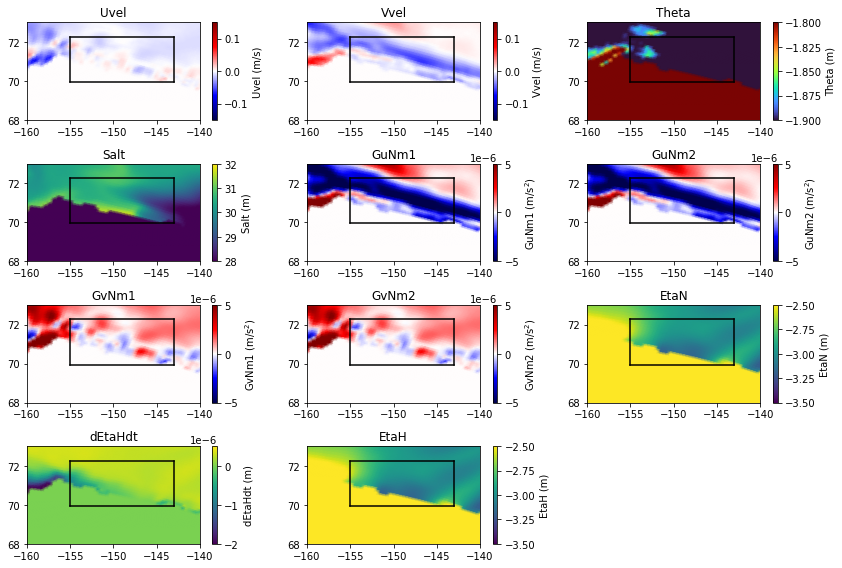

In [12]:
fig = plt.figure(figsize=(12,8))
plot_counter = 1

XC_stitched = np.vstack([np.rot90(ecco_XC_tiles[8]), np.rot90(ecco_XC_tiles[7])])
YC_stitched = np.vstack([np.rot90(ecco_YC_tiles[8]), np.rot90(ecco_YC_tiles[7])])

for variable_name in global_pickup_metadata['fldList']:

    var_grid_stitched = np.vstack([np.rot90(global_pickup_tiles[variable_name][8][0,:,:]), # just the surface for plotting
                                  np.rot90(global_pickup_tiles[variable_name][7][0,:,:])])
    
    plt.subplot(4,3,plot_counter)
    # C = plt.pcolormesh()
    C = plt.pcolormesh(XC_stitched, YC_stitched,
                       var_grid_stitched,
                       vmin=meta_dict[variable_name][0],
                       vmax=meta_dict[variable_name][1],
                       cmap=meta_dict[variable_name][2], shading='gouraud')
    plt.colorbar(C, label=variable_name+' ('+meta_dict[variable_name][3]+')',fraction=0.26)

    plt.plot(XC[:,0],YC[:,0], 'k-')
    plt.plot(XC[:,-1],YC[:,-1], 'k-')
    plt.plot(XC[0,:],YC[0,:], 'k-')
    plt.plot(XC[-1,:],YC[-1,:], 'k-')

    plt.title(variable_name)

    plt.gca().set_xlim([-160,-140])
    plt.gca().set_ylim([68,73])

    plot_counter+=1

plt.tight_layout()

plt.show()

We will use these fields as a sanity check below.

### Step 4: Prepare the grids for interpolation
In the previous notebook, we already discovered which tiles correspond to this grid:

In [13]:
# define the tile list
tile_list = [7,8]

We now read the grid on these tiles

In [14]:
# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_AngleCS_points = np.zeros((total_points, ))
ecco_AngleSN_points = np.zeros((total_points, ))
ecco_maskC_points = np.zeros((ecco_Nr, total_points))
ecco_maskW_points = np.zeros((ecco_Nr, total_points))
ecco_maskS_points = np.zeros((ecco_Nr, total_points))
ecco_hFacW_points = np.zeros((ecco_Nr, total_points))
ecco_hFacS_points = np.zeros((ecco_Nr, total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()

    ecco_AngleCS_points[points_counted:points_counted+tile_N] = ecco_AngleCS_tiles[tile_number].ravel()
    ecco_AngleSN_points[points_counted:points_counted+tile_N] = ecco_AngleSN_tiles[tile_number].ravel()
    
    for k in range(ecco_Nr):
        level_hFacC = ecco_hFacC_tiles[tile_number][k, :, :]
        if tile_number<7:
            level_hFacW = ecco_hFacW_tiles[tile_number][k, :, :]
            level_hFacS = ecco_hFacS_tiles[tile_number][k, :, :]
        else:
            level_hFacS = ecco_hFacW_tiles[tile_number][k, :, :] # these are switched due to the 
            level_hFacW = ecco_hFacS_tiles[tile_number][k, :, :] # assumptions about velocity - see note below
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        level_maskC = np.copy(level_hFacC)
        level_maskC[level_maskC>0] = 1
        level_maskW = np.copy(level_hFacW)
        level_maskW[level_maskW>0] = 1
        level_maskS = np.copy(level_hFacS)
        level_maskS[level_maskS>0] = 1
        ecco_maskC_points[k, points_counted:points_counted+tile_N] = level_maskC.ravel()
        ecco_maskW_points[k, points_counted:points_counted+tile_N] = level_maskW.ravel()
        ecco_maskS_points[k, points_counted:points_counted+tile_N] = level_maskS.ravel()
    
    points_counted += tile_N

# remove the points with positive longitude
local_indices = (ecco_XC_points<-140) & (ecco_XC_points>-160) & (ecco_YC_points>65) & (ecco_YC_points<80)
ecco_maskC_points = ecco_maskC_points[:, local_indices]
ecco_maskW_points = ecco_maskW_points[:, local_indices]
ecco_maskS_points = ecco_maskS_points[:, local_indices]
ecco_hFacW_points = ecco_hFacW_points[:, local_indices]
ecco_hFacS_points = ecco_hFacS_points[:, local_indices]
ecco_YC_points = ecco_YC_points[local_indices]
ecco_XC_points = ecco_XC_points[local_indices]

### Step 5: Subset and vertically interpolate the ECCO fields

Next, we'll read in the data fields and apply some modifications including the following:
- Rotate vector quantities to ordinal directions.
- Subset to the same ECCO indices as the grid subsets above
- Interpolate the quantities to the same vertical grid cells

In [15]:
# make a list to hold all of the ECCO grids
init_grids = []

# define a random index in the grid to test the vertical interpolation below
random_plot_index = 117

# loop through each variable to read in the grid
for variable_name in global_pickup_metadata['fldList']:
    print(' - Processing '+variable_name)
    
    if variable_name in ['Uvel','Vvel']:
        u_grid_tiles = global_pickup_tiles['Uvel']
        v_grid_tiles = global_pickup_tiles['Vvel']
        rotate = True
    elif variable_name in ['GuNm1','GvNm1']:
        u_grid_tiles = global_pickup_tiles['GuNm1']
        v_grid_tiles = global_pickup_tiles['GuNm1']
        rotate = True
    elif variable_name in ['GuNm2','GvNm2']:
        u_grid_tiles = global_pickup_tiles['GuNm2']
        v_grid_tiles = global_pickup_tiles['GuNm2']
        rotate = True
    else:
        grid_tiles = global_pickup_tiles[variable_name]
        rotate = False

    # rotate grids, if needed
    if rotate:
        grid_tiles = {}
        for tile_number in tile_list:
            zonal_grid, meridional_grid = grid.rotate_ecco_vel_grids_to_natural_grids(u_grid_tiles[tile_number][:,:,:], v_grid_tiles[tile_number][:,:,:],
                                                                                 ecco_AngleCS_tiles[tile_number], ecco_AngleSN_tiles[tile_number])
            if variable_name in ['Uvel','GuNm1','GuNm2']:
                tile_grid = zonal_grid
            if variable_name in ['Vvel','GvNm1','GvNm2']:
                tile_grid = meridional_grid
            grid_tiles[tile_number]=tile_grid

    # create a grid of zeros to fill in
    N = np.shape(grid_tiles[7])[-1]*np.shape(grid_tiles[7])[-2]
    if variable_name in ['EtaN', 'dEtaHdt', 'EtaH']:
        init_grid = np.zeros((1, N*len(tile_list)))
    else:
        init_grid = np.zeros((ecco_Nr, N*len(tile_list)))

    # loop through the tiles
    points_counted = 0
    for tile_number in tile_list:
        if variable_name in ['EtaN', 'dEtaHdt', 'EtaH']:
            init_grid[0,points_counted:points_counted+N] = \
                 grid_tiles[tile_number][0, :, :].ravel()
        else:
            for k in range(ecco_Nr):
                init_grid[k,points_counted:points_counted+N] = \
                     grid_tiles[tile_number][k, :, :].ravel()
        points_counted += N

    # remove the points with positive longitudes
    init_grid = init_grid[:,local_indices]

    # interpolate the grids to the depth levels of the model
    # make a copy of one profile as a sanity check before the vertical interpolation
    if variable_name == 'Theta':
        uninterpolated_profile = init_grid[:,random_plot_index]
    # run the interpolation, if necessary
    if variable_name not in ['EtaN', 'dEtaHdt', 'EtaH']:
        init_grid, _ = \
        vertical.interpolate_var_grid_faces_to_new_depth_levels(init_grid, ecco_maskC_points,
                                                                np.array(ecco_DRF), np.array(delR))
    # make the same copy of one profile as a sanity check after the vertical interpolation
    if variable_name == 'Theta':
        interpolated_profile = init_grid[:,random_plot_index]
    
    print('    - Min: ',np.min(init_grid[init_grid!=0]),'Max:',np.min(init_grid[init_grid!=0]))
    init_grids.append(init_grid)

 - Processing Uvel
    - Min:  -0.08290610566214271 Max: -0.08290610566214271
 - Processing Vvel
    - Min:  -0.04430016468629099 Max: -0.04430016468629099
 - Processing Theta
    - Min:  -1.9631340060043974 Max: -1.9631340060043974
 - Processing Salt
    - Min:  27.49315483496538 Max: 27.49315483496538
 - Processing GuNm1
    - Min:  -6.733970332847997e-06 Max: -6.733970332847997e-06
 - Processing GuNm2
    - Min:  -6.730665855035246e-06 Max: -6.730665855035246e-06
 - Processing GvNm1
    - Min:  -1.9571271628296576e-05 Max: -1.9571271628296576e-05
 - Processing GvNm2
    - Min:  -1.9906225304423493e-05 Max: -1.9906225304423493e-05
 - Processing EtaN
    - Min:  -3.345021387247904 Max: -3.345021387247904
 - Processing dEtaHdt
    - Min:  -2.911620113506359e-06 Max: -2.911620113506359e-06
 - Processing EtaH
    - Min:  -3.3453023134140594 Max: -3.3453023134140594


It's always a good idea to make sure the vertical interpolation looks as expected. We can do this with the profile stored in the previous cell:

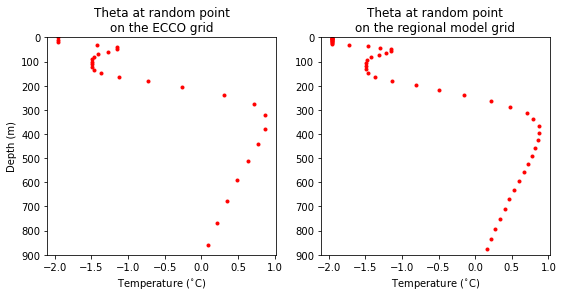

In [16]:
fig = plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(uninterpolated_profile, -1*ecco_RF[:-1], 'r.')
plt.gca().set_ylim([np.max(-1*ecco_RF[:-1]), 0])
plt.title('Theta at random point\non the ECCO grid')
plt.ylim([900,0])
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')

plt.subplot(1,2,2)
plt.plot(interpolated_profile, np.cumsum(delR), 'r.')  
plt.ylim([900,0])
plt.title('Theta at random point\non the regional model grid')
plt.xlabel('Temperature ($^{\circ}$C)')

plt.show()

### Step 6: Interpolate the Physical Fields onto the Model Grid
Next, we will interpolate the ECCO pickup fields onto the regional model domain. We will use interpolation grid we generated in the previous notebook for efficient interpolation.

Just as in the creation the interpolation grid, let's reproject the coordinates to ensure the bi-linear interpolation occurs without artefacts. We can do this with the `reprojection` model provided with **eccoseas**:

In [17]:
utm_zone_epsg = 32606
utm_coordinates = reprojection.reproject_polygon(np.column_stack([ecco_XC_points, ecco_YC_points]), 4326, utm_zone_epsg)

regional_coordinates = reprojection.reproject_polygon(np.column_stack([XC.ravel(), YC.ravel()]), 4326, utm_zone_epsg)
X = regional_coordinates[:,0].reshape(np.shape(XC))
Y = regional_coordinates[:,1].reshape(np.shape(XC))

Finally, let's use our interpolation grid to proceed with the interpolation:

In [18]:
interpolation_grid_file = os.path.join(data_folder,'NorthSlope_interpolation_grid.nc')

pickup_grids = []

# loop through each variable and corresponding ECCO grid
for variable_name, init_grid in zip(global_pickup_metadata['fldList'], init_grids):

    print('  - Interpolating the '+variable_name+' grid')
    print('    - Reading the interpolation mask')
    interpolation_grid_components = ecco_interp.read_interpolation_grid_for_variable(interpolation_grid_file, variable_name)
    interpolation_mask = interpolation_grid_components['interp_type']
    source_rows = interpolation_grid_components['source_rows']
    source_cols = interpolation_grid_components['source_cols']
    source_levels = interpolation_grid_components['source_levels']

    # read in the correct mask for each variable
    if variable_name.lower() in ['etan','detahdt','etah']:
        regional_mask = maskC[:1,:,:]
        ecco_mask = ecco_maskC_points[:1,:]
    elif variable_name.lower() in ['uvel','gunm1','gunm2']:
        regional_mask = maskW
        ecco_mask = ecco_maskW_points
    elif variable_name.lower() in ['vvel', 'gvnm1', 'gvnm2']:
        regional_mask = maskS
        ecco_mask = ecco_maskS_points
    else:
        regional_mask = maskC
        ecco_mask = ecco_maskC_points

    print('    - Running the downscale scheme')
    interpolated_grid = horizontal.downscale_3D_points_with_interpolation_mask(utm_coordinates, init_grid, ecco_mask,
                                               X, Y, regional_mask,
                                               interpolation_mask, source_rows, source_cols, source_levels,
                                               printing=True, testing=True)
    
    pickup_grids.append(interpolated_grid)

  - Interpolating the Uvel grid
    - Reading the interpolation mask
    - Running the downscale scheme
                - Working on level 0 of 81 (338039 nonzero points found)
  - Interpolating the Vvel grid
    - Reading the interpolation mask
    - Running the downscale scheme
                - Working on level 0 of 81 (337553 nonzero points found)
  - Interpolating the Theta grid
    - Reading the interpolation mask
    - Running the downscale scheme
                - Working on level 0 of 81 (338562 nonzero points found)
  - Interpolating the Salt grid
    - Reading the interpolation mask
    - Running the downscale scheme
                - Working on level 0 of 81 (338562 nonzero points found)
  - Interpolating the GuNm1 grid
    - Reading the interpolation mask
    - Running the downscale scheme
                - Working on level 0 of 81 (338039 nonzero points found)
  - Interpolating the GuNm2 grid
    - Reading the interpolation mask
    - Running the downscale scheme
        

With our interpolated fields in hand, let's write this out to a pickup file we can use for our model:

In [19]:
input_dir = '../../../configurations/alaska_north_slope/input'

In [20]:
metadata = global_pickup_metadata

# make some changes to the metadata as needed
Nr = len(delR)
metadata['nrecords'] = 8*Nr+3

print('Stacking files into a big pickup grid')
pickup_grid = np.zeros((8*Nr+3, np.shape(XC)[0], np.shape(XC)[1]))
counter = 0
for i in range(len(pickup_grids)):
    print('    - Stacking field for '+global_pickup_metadata['fldList'][i])
    var_grid = pickup_grids[i]
    print('        - Min: ',np.min(var_grid[var_grid!=0]),'Max:',np.min(var_grid[var_grid!=0]))
    pickup_grid[counter:counter+np.shape(var_grid)[0],:,:] = var_grid
    counter+=np.shape(var_grid)[0]

print('Outputting the file...')
output_file_path = os.path.join(input_dir,'pickup.0000000004')
pickup.write_mitgcm_pickup_file(output_file_path, pickup_grid, metadata)

Stacking files into a big pickup grid
    - Stacking field for Uvel
        - Min:  -0.055193915419376086 Max: -0.055193915419376086
    - Stacking field for Vvel
        - Min:  -0.013090280101968598 Max: -0.013090280101968598
    - Stacking field for Theta
        - Min:  -1.960052739776636 Max: -1.960052739776636
    - Stacking field for Salt
        - Min:  28.123663832296256 Max: 28.123663832296256
    - Stacking field for GuNm1
        - Min:  -4.8735910594595875e-06 Max: -4.8735910594595875e-06
    - Stacking field for GuNm2
        - Min:  -4.841797521728271e-06 Max: -4.841797521728271e-06
    - Stacking field for GvNm1
        - Min:  -1.777832248732874e-06 Max: -1.777832248732874e-06
    - Stacking field for GvNm2
        - Min:  -1.796065479812738e-06 Max: -1.796065479812738e-06
    - Stacking field for EtaN
        - Min:  -3.181282681367569 Max: -3.181282681367569
    - Stacking field for dEtaHdt
        - Min:  -8.241635845179116e-07 Max: -8.241635845179116e-07
    - Stac

### Step 7: Plotting the Initial Condition Fields
Now that the fields have been generated, we will plot them to ensure they look as expected.

First, let's read in the fields from the file we made to ensure this file was made correctly:

In [21]:
pickup_file_path = os.path.join(input_dir,'pickup.0000000004')
regional_pickup_grids, regional_pickup_metadata = pickup.read_mitgcm_pickup_file(pickup_file_path, Nr=len(delR))

Then, create all of the subplots:

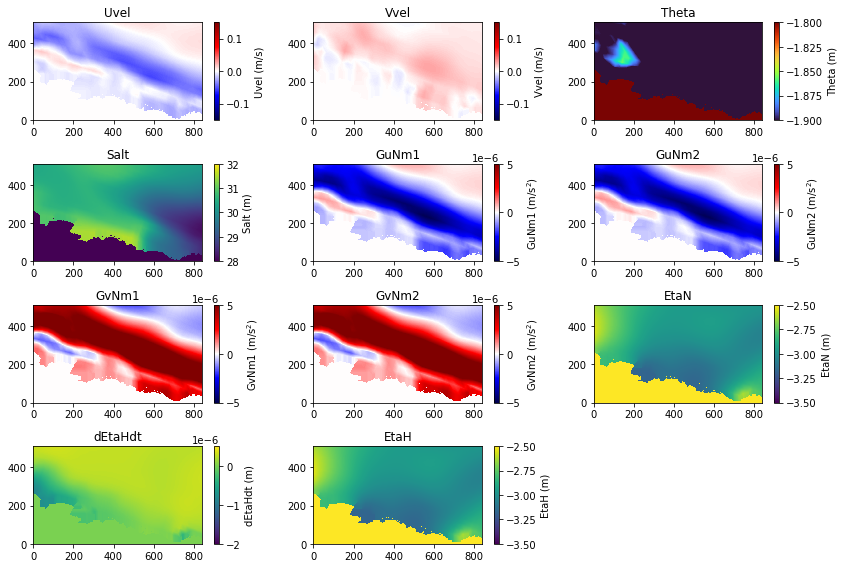

In [22]:
fig = plt.figure(figsize=(12,8))

plot_counter = 1
for variable_name in regional_pickup_metadata['fldList']:
    init_grid = regional_pickup_grids[variable_name]
    
    plt.subplot(4,3,plot_counter)
    C = plt.pcolormesh(init_grid[0,:,:], # just the surface for plotting
                       vmin=meta_dict[variable_name][0],
                       vmax=meta_dict[variable_name][1],
                       cmap=meta_dict[variable_name][2])
    plt.colorbar(C, label=variable_name+' ('+meta_dict[variable_name][3]+')',fraction=0.26)
    plt.title(variable_name)

    plot_counter+=1

plt.tight_layout()

plt.show()

These physics fields look ok. Now we need to make our the rest of our initial conditions.